In [18]:
import torch
import torch.nn.functional as F
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.nn.models import GraphSAGE, GCN, GAT
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch_geometric.loader import NeighborLoader
from torch_geometric.datasets import Reddit, Reddit2, Planetoid, WikipediaNetwork
from torch_geometric.utils import degree
from functools import partial

from open_dataset import load_reddit2,load_folds
from EarlyStopping import EarlyStopping
from handle_meta_data import load_yml
#from evaluation import eval_validation_model

In [15]:
def train(og_model, optimizer, data, device, log_all):
    
    og_model = og_model.to(device)
    data = data.to(device)
    #data_sampled = data

    model_path = Path("model_backup/tests_reddit_gcn_backup.pth")
    es = EarlyStopping(patience=5, path=Path(model_path))
    

    loss_list = []
    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    
    for epoch in tqdm(range(20)):
        og_model.train()
        data = data.to(device)

        nl = NeighborLoader(data, 
                            num_neighbors=[64, 16], 
                            num_workers=4, 
                            batch_size=128, 
                            pin_memory=True,
                            input_nodes = data.train_mask.cpu())


        loss_epoch = []
        for data_sampled in nl:
            optimizer.zero_grad()
            og_model.train()
            
            logits = og_model(data_sampled.x, data_sampled.edge_index)
            out = F.softmax(logits, dim=1)
            loss = F.cross_entropy(out[data_sampled.train_mask], data_sampled.y[data_sampled.train_mask])
            
            loss.backward()
            optimizer.step()
            
            loss_epoch.append(loss)
            
        loss_list.append(torch.Tensor(loss_epoch).mean())
    

        with torch.no_grad():
            og_model.eval()
            data = data.to(device)
            pred = og_model(data.x, data.edge_index).argmax(dim=1)

            train_acc = accuracy_score(pred[data.train_mask].cpu().numpy(), data.y[data.train_mask].cpu().numpy())
            train_acc_list.append(train_acc)
            
            val_acc = accuracy_score(pred[data.val_mask].cpu().numpy(), data.y[data.val_mask].cpu().numpy())
            val_acc_list.append(val_acc)
            
            test_acc = accuracy_score(pred[data.test_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy())
            test_acc_list.append(test_acc)
            
        

        if es(val_acc, og_model):
            og_model.load_state_dict(torch.load(model_path))
            break

    return loss_list, train_acc_list, val_acc_list, test_acc_list

In [21]:
dataset = Reddit2(root="dataset")
#dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
data

Data(x=[232965, 602], edge_index=[2, 23213838], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])

In [22]:
deg = degree(data.edge_index[0,:])
print(deg.max(), deg.mean(), deg.median() ,deg.min())

tensor(3649.) tensor(99.6452) tensor(67.) tensor(0.)


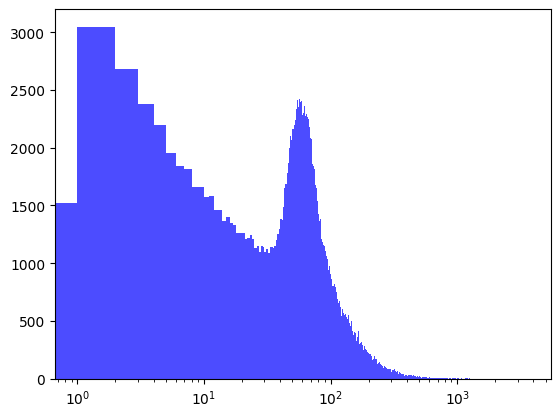

In [23]:
plt.hist(deg, bins=int(deg.max()), color='blue', alpha=0.7)plt.xscale("log")
plt.savefig("reddit2.png")

In [6]:
from torch_geometric.utils import contains_self_loops,is_undirected

print(contains_self_loops(data.edge_index), is_undirected(data.edge_index))

False True


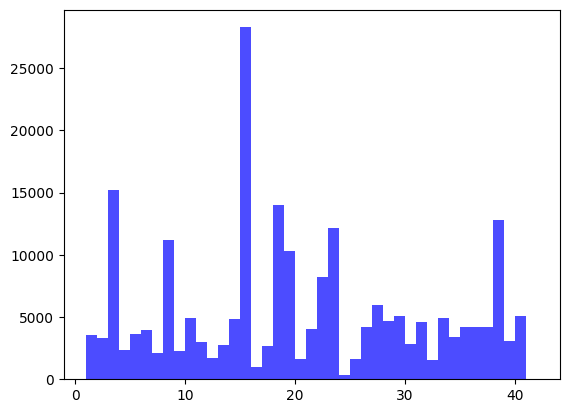

In [7]:
uq, counts = torch.unique(data.y[data.train_mask], return_counts=True)
plt.hist(data.y, bins=41, range=(1, 42), color='blue', alpha=0.7)
binrange = list(range(1, 42,2))
#plt.xticks(binrange)

In [8]:
normalize = partial(F.normalize, p=2, dim=1)

model =GCN(in_channels = data.x.shape[1],
                 hidden_channels = 256,
                 out_channels = int(data.y.max())+1,
                 dropout = 0.7,
                 #norm = "layer_norm",
                 num_layers = 2)
                 #kwars = {"heads" : 8})

In [9]:
lr = 0.01
weight_decay = 0.0
device = torch.device(*('cuda', 0) if torch.cuda.is_available() else 'cpu')
log_all = True

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr= lr, 
                             weight_decay=weight_decay)
loss, train_acc, val_acc, testacc= train(model, optimizer, data, device, log_all)

  0%|                                                                                                                | 0/20 [00:12<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 109.53 GiB (GPU 0; 79.11 GiB total capacity; 4.78 GiB already allocated; 71.07 GiB free; 6.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.plot(loss)

In [ ]:
plt.plot(train_acc)

In [ ]:
plt.plot(val_acc)

In [ ]:
plt.plot(testacc)

In [ ]:
testacc[-1]